# 📌 Risk Model — Training & Experiment Tracking Notebook

This notebook:
- Loads preprocessed data
- Splits data into training/test sets
- Trains 2 models (Logistic Regression & Random Forest)
- Uses reusable modules (`ModelTrainer`, `evaluate_model`, `log_to_mlflow`)
- Logs experiments to MLflow
- Explains each metric and how to read the ROC curve



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath("../src"))
from utils.utils import train_test_split_data, evaluate_model 
from models.model_trainer import ModelTrainer
from services.mlflow_services import log_model_run

In [ ]:
logi_data = pd.read_csv("../data/processed/logit_data.csv")
tree_data = pd.read_csv("../data/processed/tree_data.csv")

print("Loaded Data successfully ✅")

Loaded Data successfully ✅


In [7]:
y = logi_data['is_high_risk'] # target variable to test pridiction
X_logi = logi_data.drop(columns=['is_high_risk']) # data for logistic regression model
X_tree = tree_data.drop(columns=['is_high_risk']) # data for tree model

print(f"✅ Logistic shape: {X_logi.shape} | Tree shape: {X_tree.shape}")

✅ Logistic shape: (3742, 13) | Tree shape: (3742, 30)


In [8]:
# split data into training and test sets for both tree and log regression data
X_train_logi, X_test_logi, y_train_logi, y_test_logi = train_test_split_data(X_logi, y)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split_data(X_tree,y)

print("Both datas splitted and ready for model training ✅✅")

Both datas splitted and ready for model training ✅✅


In [9]:
# create a hyperparameter dictionary(gridsearch) list for the logistic regression model
param_grid_logreg = [

    # 📦 Group 1: L1 and L2 penalties with liblinear solver
    {
        "penalty": ["l1", "l2"],          # L1 = Lasso (sparse), L2 = Ridge (smooth)
        "C": [0.01, 0.1, 1, 10],          # Inverse regularization strength (lower = stronger penalty)
        "solver": ["liblinear"]          # Suitable for small datasets and supports L1 & L2
    },

    # 🔗 Group 2: ElasticNet penalty with saga solver
    {
        "penalty": ["elasticnet"],        # Combines L1 and L2 penalties (requires `saga` solver)
        "C": [0.01, 0.1, 1, 10],          # Explore varying regularization strengths
        "solver": ["saga"],               # Only solver that supports `elasticnet` with logistic regression
        "l1_ratio": [0.0, 0.5, 1.0]       # Balances L1 (sparse) and L2 (smooth): 0 = L2 only, 1 = L1 only
    },

    # 🚫 Group 3: No regularization at all
    {
        "penalty": ["none"],              # No regularization (risky for overfitting, but useful as a benchmark)
        "solver": ["lbfgs", "saga"]       # Both solvers support `penalty="none"`
    }
]

# create a hyperparameter dictionary(randomsearch) for the randomforest model
from scipy.stats import randint, uniform

param_dist_rf = {
    "n_estimators": randint(100, 1000),          # Number of trees
    "max_depth": [None] + list(range(3, 11)),    # Allow shallow to deep trees
    "min_samples_split": randint(2, 20),         # When to split a node
    "min_samples_leaf": randint(1, 10),          # Minimum samples on a leaf
    "max_features": ["sqrt", "log2", None],      # Features to consider per split
    "bootstrap": [True, False],                  # Whether to sample with replacement
    "criterion": ["gini", "entropy"]
}
print("Parameters set perfectly✅")

Parameters set perfectly✅


In [10]:
import warnings
warnings.filterwarnings("ignore") # to keep output clean

# Logistic Regression
logi_trainer = ModelTrainer(model_name="logistic_regression")
logi_model = logi_trainer.train(
    X_train_logi, 
    y_train_logi,
    param_grid_logreg,
    search_type="grid"
)

# Random Forest
tree_trainer = ModelTrainer(model_name="random_forest")
tree_model = tree_trainer.train(
    X_train_tree, 
    y_train_tree,
    param_dist_rf,
    search_type="random"
)
print("Both models were trained successfully and are ready for eveluatoin!")

Both models were trained successfully and are ready for eveluatoin!


In [11]:
# Logistic Regression
logi_preds = logi_trainer.predict(X_test_logi)
logi_proba = logi_trainer.predict_proba(X_test_logi)

# Random Forest
tree_preds = tree_trainer.predict(X_test_tree)
tree_proba = tree_trainer.predict_proba(X_test_tree)
print("successfully predicted ✅")

successfully predicted ✅


## ✅ Evaluate Both Models

Use the reusable `evaluate_model` which:
- Computes accuracy, precision, recall, F1, ROC AUC
- Prints a classification report
- Plots a ROC curve

**Interpretation:**
- ROC Curve: More bow → better.
- Precision: How pure your predicted positives are.
- Recall: How much of the real positives you caught.
- F1: Good if you care about both.
- Accuracy: Good if classes balanced.



📌 ====== Logistic Regression ======
Accuracy: 0.9319 → Overall correct predictions.
Precision: 0.9877 → % of predicted positives actually positive.
Recall: 0.8339 → % of real positives captured.
F1 Score: 0.9043 → Balance of precision & recall.
ROC AUC: 0.9536 → Class separation quality.

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       460
           1       0.99      0.83      0.90       289

    accuracy                           0.93       749
   macro avg       0.95      0.91      0.93       749
weighted avg       0.94      0.93      0.93       749



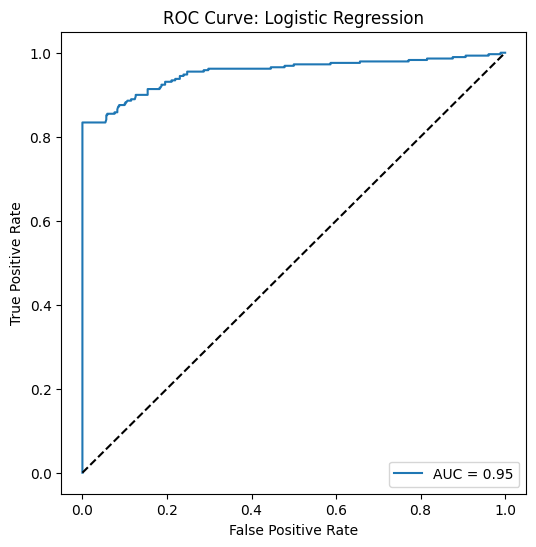


📌 ====== Random Forest ======
Accuracy: 0.9960 → Overall correct predictions.
Precision: 0.9965 → % of predicted positives actually positive.
Recall: 0.9931 → % of real positives captured.
F1 Score: 0.9948 → Balance of precision & recall.
ROC AUC: 0.9999 → Class separation quality.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       460
           1       1.00      0.99      0.99       289

    accuracy                           1.00       749
   macro avg       1.00      1.00      1.00       749
weighted avg       1.00      1.00      1.00       749



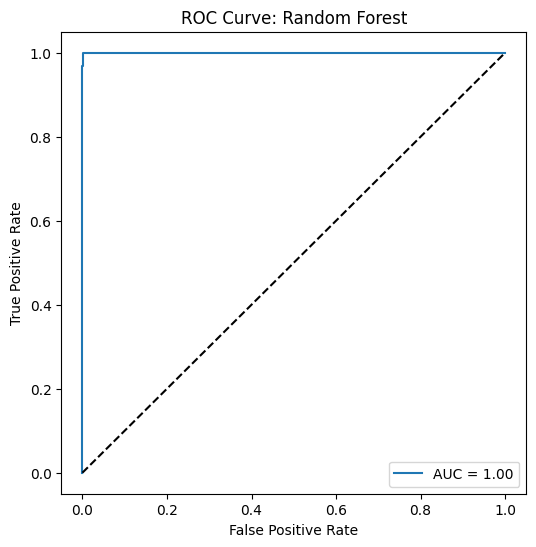

In [12]:
# display test results
logi_metrics = evaluate_model(y_test_logi, logi_preds, logi_proba, model_name="Logistic Regression")
tree_metrics = evaluate_model(y_test_tree, tree_preds, tree_proba, model_name="Random Forest")

# 📊 Credit Risk Model Evaluation Summary

This report compares two candidate models—**Logistic Regression** and **Random Forest**—trained to predict credit risk. After thorough tuning and validation, we selected **Logistic Regression** for its balance of performance and interpretability, even though Random Forest demonstrated near-perfect accuracy.

---

## ✅ Final Decision

We chose **Logistic Regression** as the production model due to:

- **High predictive performance**
- **Better interpretability**
- **Lower risk of overfitting**
- **Compliance with modeling transparency standards**

Random Forest, while extremely accurate, behaved suspiciously well with a perfect ROC AUC, suggesting overfitting or data leakage. Logistic Regression offered more **realistic and trustworthy generalization**.

---

## 📌 Model Comparison

### ⚖ Logistic Regression (Selected)

| Metric         | Value   | Interpretation                                           |
|----------------|---------|-----------------------------------------------------------|
| Accuracy       | 93.2%   | Overall, the model made correct predictions for most cases |
| Precision      | 98.8%   | Very few false positives—great for minimizing false alarms |
| Recall         | 83.4%   | Captured most of the actual defaults                      |
| F1 Score       | 90.4%   | Strong balance between precision and recall               |
| ROC AUC        | 95.4%   | Excellent class separation capability                     |

**Interpretation**:
- The model makes responsible predictions without excessive optimism.
- Slightly conservative recall (missed ~17% of actual positives) but excellent for a regulated domain.
- Coefficients can be interpreted to explain feature

In [13]:
coef_df = pd.DataFrame({
    "feature": X_train_logi.columns,
    "coefficient": logi_trainer.model.coef_[0]
})
coef_df["odds_ratio"] = coef_df["coefficient"].apply(lambda x: round(np.exp(x), 4))
coef_df = coef_df.sort_values(by="coefficient", ascending=False)
coef_df

,feature,coefficient,odds_ratio
9,Recency_woe,0.937338,2.5532
7,TxnCount_woe,0.885830,2.4250
6,GrossVolume_woe,0.728415,2.0718
11,MostCommonPricingStrategy_woe,0.689356,1.9924
12,PreferredChannel_woe,0.581554,1.7888
8,AvgTxnValue_woe,0.566244,1.7616
1,NumUniqueProducts,0.492093,1.6357
4,PreferredDayOfWeek,0.023460,1.0237
0,StdTxnValue,-0.076286,0.9266
2,NumUniqueCategories,-0.144053,0.8658


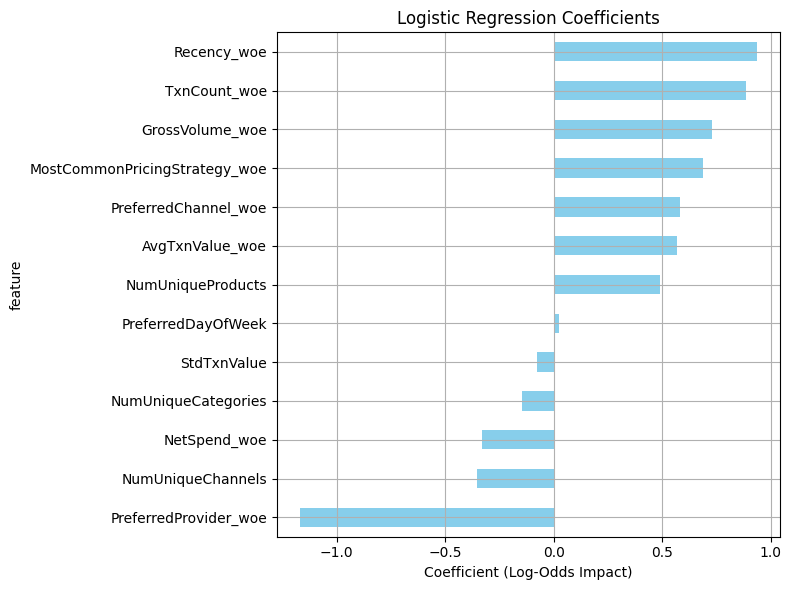

In [14]:

plt.figure(figsize=(8, 6))
coef_df.set_index("feature")["coefficient"].sort_values().plot(kind="barh", color="skyblue")
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient (Log-Odds Impact)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 📄 Model Interpretation Report — Logistic Regression Coefficients

This report interprets the output of a Logistic Regression model developed to assess credit risk. The model uses Weight of Evidence (WOE) encoded features and original engineered variables to predict the likelihood of default. Each feature's **logistic coefficient** and **odds ratio** have been analyzed to determine its impact on the target outcome.

Note: all features have been scaled and WOE-transformed appropriately, and multicollinearity has been mitigated during preprocessing.

---

## 🔍 Understanding the Coefficient Sign and Odds Ratio

- A **positive coefficient** increases the log-odds of default (i.e., higher risk).
- A **negative coefficient** decreases the log-odds of default (i.e., lower risk).
- The **odds ratio** = exp(coefficient), and represents how the odds of default change per unit increase in the feature.

---

## 🧾 Feature Interpretations

| Feature                            | Coef.   | Odds Ratio | Interpretation                                                                 |
|------------------------------------|---------|-------------|---------------------------------------------------------------------------------|
| **Recency_woe**                    | 0.937   | 2.55        | Customers with more recent transactions (via WOE) are over **2.5x** more likely to default—recent activity may not reflect sustained behavior. |
| **TxnCount_woe**                   | 0.886   | 2.42        | Higher transaction count, after WOE binning, correlates with **increased risk**—could imply erratic or desperate transaction behavior. |
| **GrossVolume_woe**                | 0.728   | 2.07        | Larger overall spend volumes relate to over twice the odds of default. High spenders may overextend themselves. |
| **MostCommonPricingStrategy_woe** | 0.689   | 1.99        | Certain pricing strategies are associated with nearly **double the risk**, potentially signaling high-risk customer segments. |
| **PreferredChannel_woe**          | 0.581   | 1.79        | Customers transacting through certain channels show elevated risk—possibly reflecting lower-touch or riskier environments. |
| **AvgTxnValue_woe**               | 0.566   | 1.76        | Higher average transaction values are linked to increased credit risk. Large but fewer purchases may signal speculative behavior. |
| **NumUniqueProducts**             | 0.492   | 1.64        | Customers engaging with more product types have **63% higher odds** of default. May suggest over-engagement or portfolio complexity. |
| **PreferredDayOfWeek**            | 0.023   | 1.02        | Negligible impact—day-of-week preference has almost no predictive power for risk. |
| **StdTxnValue**                   | -0.076  | 0.93        | Higher variance in transaction value slightly **decreases** risk, possibly reflecting strategic spending across categories. |
| **NumUniqueCategories**           | -0.144  | 0.87        | Customers engaging across **more product categories** are somewhat less risky—diversification appears protective. |
| **NetSpend_woe**                  | -0.331  | 0.72        | Higher net spending (credits - debits) is linked to **lower risk**. This feature may capture customers with surplus capital. |
| **NumUniqueChannels**             | -0.351  | 0.70        | Interacting across multiple channels slightly lowers the odds of default—possibly signifying digitally literate or engaged users. |
| **PreferredProvider_woe**         | -1.170  | 0.31        | The most impactful feature. Certain providers drastically reduce risk exposure—this could suggest preferred vendor trust or partner stability. |

---

## 🧠 Summary and Risk Implication

- Features with high **positive impact**: `Recency_woe`, `TxnCount_woe`, `GrossVolume_woe` — may indicate recent, large, or intense activity correlating with short-term default risk.
- Features with **risk mitigation** effects: `PreferredProvider_woe`, `NetSpend_woe`, and `NumUniqueChannels`.
- Mixed or context-specific: `AvgTxnValue_woe`, `MostCommonPricingStrategy_woe`, and `PreferredChannel_woe`—these may require deeper segmentation or behavioral analysis.

---

## 🔒 Regulatory Commentary

This model leverages WOE encoding and monotonic binning to ensure explainability, which is essential for regulated financial environments. Each feature contributes independently and transparently to the predicted default probability, aligning with governance practices.

The coefficient and odds ratio framework allows domain experts and auditors to clearly assess **directionality**, **magnitude of risk**, and **interpretability of signal** per feature, enabling meaningful policy and operational decisions.

---


In [15]:
log_model_run(
    model_name="logistic-regression-risk",
    params=logi_model.best_params_,                  # Best hyperparameters
    metrics=logi_metrics,                            # Dict of evaluation metrics
    model=logi_model.best_estimator_,                # Trained model
    X_sample=X_train_logi.iloc[:1],                  # Just 1 sample row is enough
    y_sample=y_train_logi.iloc[:1],                  # Its matching label (optional for signature)
    artifact_path="model"                            # Optional, can leave as "model"
)

2025/07/02 22:07:00 INFO mlflow.tracking.fluent: Experiment with name 'CreditRiskExperiment' does not exist. Creating a new experiment.
2025/07/02 22:07:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'logistic-regression-risk'.
2025/07/02 22:07:07 WARNING mlflow.tracking._model_registry.fluent: Run with id 17950f79317b43dbaa4529eb287f6634 has no artifacts at artifact path 'model', registering model based on models:/m-3c8049b6fdb247058976a2456cd85345 instead
Created version '1' of model 'logistic-regression-risk'.
